# Explorador 3D de Mallas (OBJ / STL / GLTF)

Notebook para cargar, analizar y visualizar mallas 3D con `trimesh`, `vedo`, `numpy` y `matplotlib`.

Incluye:
- Carga robusta de archivos `.obj`, `.stl`, `.gltf` y `.glb`.
- Análisis estructural: vértices, aristas y caras.
- Visor 3D interactivo para alternar entre caras, aristas, vértices o todo junto.

In [1]:
%%capture
%pip install -q numpy trimesh vtk vedo matplotlib ipython imageio imageio-ffmpeg

In [2]:
import os
from pathlib import Path
from typing import Dict

import imageio.v2 as imageio
import numpy as np
import trimesh
import vedo
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import Image, Video, display
from mpl_toolkits.mplot3d.art3d import Line3DCollection, Poly3DCollection

# Configuración general de estilo para gráficos 2D
plt.style.use('seaborn-v0_8-whitegrid')

def configure_view_backend(view_mode: str = 'inline') -> str:
    """
    Configura backend de vedo según modo de visualización:
    - 'inline': render embebido en notebook (k3d/matplotlib).
    - 'window': ventana externa VTK (requiere entorno gráfico).
    """
    mode = view_mode.strip().lower()

    if mode not in {'inline', 'window'}:
        raise ValueError("view_mode debe ser 'inline' o 'window'.")

    if mode == 'window':
        if not os.environ.get('DISPLAY'):
            raise EnvironmentError(
                'No hay DISPLAY activo. No es posible abrir ventana externa en este entorno.'
            )

        ip = globals().get('get_ipython', lambda: None)()
        if ip is not None:
            try:
                ip.run_line_magic('gui', 'qt')
            except Exception:
                pass

        vedo.settings.default_backend = 'vtk'
        return 'vtk'

    try:
        vedo.settings.default_backend = 'k3d'
        return 'k3d'
    except Exception:
        vedo.settings.default_backend = 'matplotlib'
        return 'matplotlib'

In [3]:
SUPPORTED_EXTENSIONS = {'.obj', '.stl', '.gltf', '.glb'}

def load_mesh(file_path: str | Path) -> trimesh.Trimesh:
    """
    Carga una malla desde OBJ/STL/GLTF/GLB y devuelve un objeto trimesh.Trimesh.
    Si el archivo contiene una escena (varias geometrías), las concatena en una sola malla.
    """
    path = Path(file_path)

    if not path.exists():
        raise FileNotFoundError(f'No se encontró el archivo: {path}')

    ext = path.suffix.lower()
    if ext not in SUPPORTED_EXTENSIONS:
        raise ValueError(
            f'Formato no soportado: {ext}. Usa uno de: {sorted(SUPPORTED_EXTENSIONS)}'
        )

    if ext in {'.gltf', '.glb'}:
        loaded = trimesh.load(path, force='scene')
    else:
        loaded = trimesh.load(path)

    if isinstance(loaded, trimesh.Scene):
        meshes = [g for g in loaded.geometry.values() if isinstance(g, trimesh.Trimesh)]
        if not meshes:
            raise ValueError('La escena no contiene geometrías de malla válidas.')
        mesh = trimesh.util.concatenate(meshes)
    elif isinstance(loaded, trimesh.Trimesh):
        mesh = loaded
    else:
        raise TypeError(f'Tipo cargado no soportado: {type(loaded)}')

    if mesh.vertices.shape[0] == 0 or mesh.faces.shape[0] == 0:
        raise ValueError('La malla cargada está vacía (sin vértices o sin caras).')

    return mesh

In [4]:
def compute_mesh_stats(mesh: trimesh.Trimesh) -> Dict[str, int]:
    """Calcula métricas estructurales básicas de la malla."""
    return {
        'vertices': int(mesh.vertices.shape[0]),
        'edges': int(mesh.edges_unique.shape[0]),
        'faces': int(mesh.faces.shape[0]),
    }


def plot_mesh_stats(stats: Dict[str, int]) -> None:
    """Muestra métricas en consola y en gráfico de barras."""
    print('Métricas del modelo:')
    for key, value in stats.items():
        print(f'  - {key.capitalize()}: {value}')

    labels = ['Vértices', 'Aristas', 'Caras']
    values = [stats['vertices'], stats['edges'], stats['faces']]

    fig, ax = plt.subplots(figsize=(7, 4))
    bars = ax.bar(labels, values, color=['#f6c85f', '#6f4e7c', '#4c78a8'])
    ax.set_title('Resumen estructural de la malla')
    ax.set_ylabel('Cantidad')

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}',
                ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

In [5]:
def _edge_segments_from_mesh(mesh: trimesh.Trimesh) -> np.ndarray:
    """Convierte aristas únicas por índice en segmentos 3D con shape (N, 2, 3)."""
    return mesh.vertices[mesh.edges_unique]


def _normalize_mpl_color(color_value: str, fallback: str = 'royalblue'):
    """Convierte colores tipo vedo/matplotlib a un formato válido para matplotlib."""
    try:
        return mcolors.to_rgba(color_value)
    except ValueError:
        try:
            # Soporta nombres de vedo como 'blue5', 'green5', etc.
            rgb = vedo.get_color(color_value)
            return (*rgb, 1.0) if len(rgb) == 3 else tuple(rgb)
        except Exception:
            return mcolors.to_rgba(fallback)


def _build_component_actors(
    mesh: trimesh.Trimesh,
    face_color: str,
    edge_color: str,
    vertex_color: str,
    face_alpha: float,
    edge_width: float,
    point_radius: float,
 ):
    """Construye actores de caras, aristas y vértices para el visor."""
    edge_segments = _edge_segments_from_mesh(mesh)
    faces_actor = vedo.Mesh([mesh.vertices, mesh.faces]).c(face_color).alpha(face_alpha)
    edges_actor = vedo.Lines(edge_segments, c=edge_color, lw=edge_width)
    vertices_actor = vedo.Points(mesh.vertices, c=vertex_color, r=point_radius)
    return faces_actor, edges_actor, vertices_actor


def _set_component_visibility(mode: str, faces_actor, edges_actor, vertices_actor) -> None:
    """Activa/desactiva visibilidad de componentes geométricos."""
    mode = mode.lower()
    if mode == 'vertices':
        faces_actor.off(); edges_actor.off(); vertices_actor.on()
    elif mode == 'edges':
        faces_actor.off(); edges_actor.on(); vertices_actor.off()
    elif mode == 'faces':
        faces_actor.on(); edges_actor.off(); vertices_actor.off()
    else:
        faces_actor.on(); edges_actor.on(); vertices_actor.on()


def _register_component_shortcuts(plotter: vedo.Plotter, faces_actor, edges_actor, vertices_actor) -> None:
    """
    Atajos en ventana 3D:
    - v: solo vértices
    - e: solo aristas
    - f: solo caras
    - t: todo
    """
    def _on_key(event):
        key = str(
            getattr(event, 'keyPressed', getattr(event, 'keypress', getattr(event, 'key', '')))
        ).lower()

        if key in {'1', '2', '3', 'a'}:
            print("Usa atajos: V (vértices), E (aristas), F (caras), T (todo).")
            return

        if key == 'v':
            _set_component_visibility('vertices', faces_actor, edges_actor, vertices_actor)
            print('Vista: solo vértices')
        elif key == 'e':
            _set_component_visibility('edges', faces_actor, edges_actor, vertices_actor)
            print('Vista: solo aristas')
        elif key == 'f':
            _set_component_visibility('faces', faces_actor, edges_actor, vertices_actor)
            print('Vista: solo caras')
        elif key == 't':
            _set_component_visibility('all', faces_actor, edges_actor, vertices_actor)
            print('Vista: todo')
        else:
            return

        plotter.render()

    for event_name in ('key press', 'KeyPress', 'keypress'):
        try:
            plotter.add_callback(event_name, _on_key)
            print("Atajos: [V]=Vértices [E]=Aristas [F]=Caras [T]=Todo [q|Esc]=Cerrar")
            return
        except Exception:
            pass

    print('No se pudieron registrar atajos de teclado en este backend.')


def render_mesh_components(
    mesh: trimesh.Trimesh,
    title: str = 'Visualización de componentes geométricos',
    face_color: str = 'lightcyan',
    edge_color: str = 'blue5',
    vertex_color: str = 'orange',
    face_alpha: float = 0.45,
    edge_width: float = 1.2,
    point_radius: float = 6.0,
    view_mode: str = 'inline',
) -> vedo.Plotter:
    """Renderiza caras, aristas y vértices con colores distintos usando vedo."""
    mode = view_mode.strip().lower()

    vedo_mesh, vedo_edges, vedo_vertices = _build_component_actors(
        mesh=mesh,
        face_color=face_color,
        edge_color=edge_color,
        vertex_color=vertex_color,
        face_alpha=face_alpha,
        edge_width=edge_width,
        point_radius=point_radius,
    )

    plotter = vedo.Plotter(title=title, axes=0, bg='white')

    if mode == 'window':
        _register_component_shortcuts(plotter, vedo_mesh, vedo_edges, vedo_vertices)
        plotter.show(vedo_mesh, vedo_edges, vedo_vertices, interactive=False)
        print("Ventana 3D abierta. Presiona 'q' o 'Esc' para cerrar.")
        plotter.interactive().close()
    else:
        plotter.show(vedo_mesh, vedo_edges, vedo_vertices, interactive=True)

    return plotter


def _rotate_vertices_y(vertices: np.ndarray, angle_deg: float, center: np.ndarray) -> np.ndarray:
    """Rota vértices alrededor del eje Y con centro de referencia."""
    angle = np.deg2rad(angle_deg)
    rot = np.array([
        [np.cos(angle), 0.0, np.sin(angle)],
        [0.0, 1.0, 0.0],
        [-np.sin(angle), 0.0, np.cos(angle)],
    ])
    return (vertices - center) @ rot.T + center


def export_rotation_animation(
    mesh: trimesh.Trimesh,
    output_path: str | Path = 'outputs/mesh_rotation.gif',
    steps: int = 72,
    angle_step: float = 5.0,
    fps: int = 18,
    width: int = 900,
    height: int = 700,
    elev: float = 20.0,
    zoom: float = 0.75,
    face_color: str = 'lightcyan',
    edge_color: str = 'blue5',
    vertex_color: str = 'orange',
    face_alpha: float = 0.45,
    edge_width: float = 1.1,
    point_radius: float = 5.0,
) -> Path:
    """
    Exporta una animación rotando la malla a GIF (.gif) o video MP4 (.mp4).
    """
    out = Path(output_path)
    out.parent.mkdir(parents=True, exist_ok=True)

    suffix = out.suffix.lower()
    if suffix not in {'.gif', '.mp4'}:
        raise ValueError("output_path debe terminar en .gif o .mp4")
    if not (0 < zoom <= 1.0):
        raise ValueError("zoom debe estar en el rango (0, 1].")

    face_color_mpl = _normalize_mpl_color(face_color, fallback='lightcyan')
    edge_color_mpl = _normalize_mpl_color(edge_color, fallback='royalblue')
    vertex_color_mpl = _normalize_mpl_color(vertex_color, fallback='orange')

    verts = mesh.vertices
    faces = mesh.faces
    edges = mesh.edges_unique
    center = verts.mean(axis=0)

    mins = verts.min(axis=0)
    maxs = verts.max(axis=0)
    radius = float((maxs - mins).max() / 2.0)
    if radius == 0:
        radius = 1.0
    radius *= zoom

    frames = []
    fig_w = max(width / 100.0, 4)
    fig_h = max(height / 100.0, 3)

    for i in range(steps):
        angle = i * angle_step
        rotated = _rotate_vertices_y(verts, angle, center)

        fig = plt.figure(figsize=(fig_w, fig_h), dpi=100)
        ax = fig.add_subplot(111, projection='3d')
        ax.set_axis_off()

        poly = Poly3DCollection(
            rotated[faces],
            facecolor=face_color_mpl,
            alpha=face_alpha,
            edgecolor='none',
        )
        ax.add_collection3d(poly)

        lines = Line3DCollection(
            rotated[edges],
            colors=edge_color_mpl,
            linewidths=edge_width,
        )
        ax.add_collection3d(lines)

        ax.scatter(
            rotated[:, 0], rotated[:, 1], rotated[:, 2],
            c=[vertex_color_mpl],
            s=max(point_radius, 1.0) * 2.0,
            depthshade=False,
        )

        ax.set_xlim(center[0] - radius, center[0] + radius)
        ax.set_ylim(center[1] - radius, center[1] + radius)
        ax.set_zlim(center[2] - radius, center[2] + radius)
        ax.set_box_aspect((1, 1, 1))
        ax.view_init(elev=elev, azim=angle)

        fig.canvas.draw()
        frame = np.asarray(fig.canvas.buffer_rgba())[:, :, :3].copy()
        frames.append(frame)
        plt.close(fig)

    if suffix == '.gif':
        frame_duration = 1.0 / max(fps, 1)
        imageio.mimsave(out, frames, duration=frame_duration, loop=0)
        display(Image(filename=str(out)))
    else:
        try:
            imageio.mimsave(out, frames, fps=fps, codec='libx264', quality=8)
        except Exception as exc:
            raise RuntimeError(
                "No se pudo exportar MP4. Instala/actualiza imageio-ffmpeg o usa salida .gif."
            ) from exc
        display(Video(filename=str(out), embed=True))

    return out

## Uso
1. Define `VIEW_MODE = 'inline'` o `VIEW_MODE = 'window'`.
2. Ajusta la ruta del modelo en `MODEL_PATH`.
3. Ejecuta la celda principal para cargar, analizar y visualizar.
4. En modo `window`, usa atajos dentro de la ventana: `v` vértices, `e` aristas, `f` caras, `t` todo, `q`/`Esc` cerrar.
5. La animación se exporta automáticamente al ejecutar la celda principal.

Notas rápidas:
- `window` abre ventana externa (requiere entorno gráfico Linux con `DISPLAY`).
- Si usarás `window`, instala dependencias: `pip install pyqt5 pyopengl`.
- Para exportar video MP4 instala: `pip install imageio imageio-ffmpeg`.
- El plano/sistema cartesiano está desactivado en el visor 3D.

Métricas del modelo:
  - Vertices: 3012
  - Edges: 3762
  - Faces: 1504


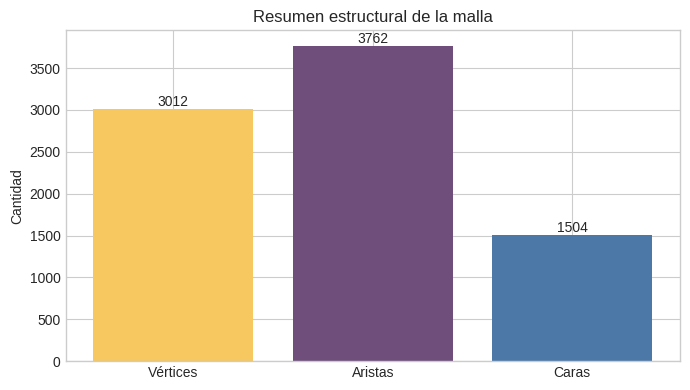

Atajos: [V]=Vértices [E]=Aristas [F]=Caras [T]=Todo [q|Esc]=Cerrar
Ventana 3D abierta. Presiona 'q' o 'Esc' para cerrar.
Vista: solo aristas
Vista: solo vértices
Vista: solo caras
Vista: todo
Vista: todo


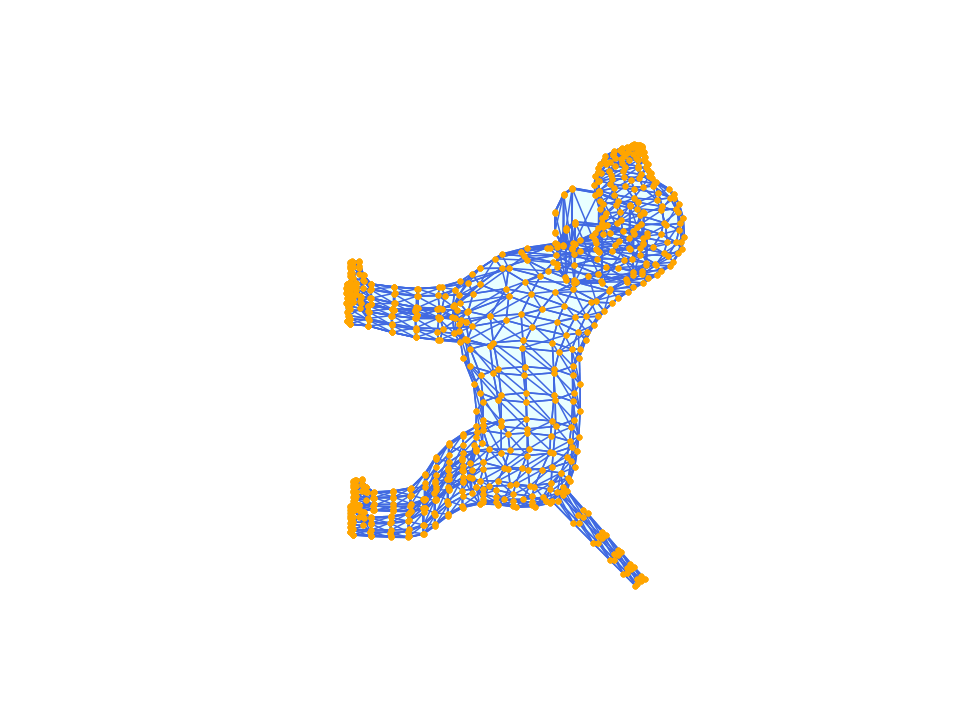

In [6]:
# Cambia modo de visualización: 'inline' o 'window'
VIEW_MODE = 'window'

# Exportación requerida por la entrega
ANIMATION_FORMAT = '.gif'

# Ejemplo: cambia esta ruta por un archivo .obj, .stl, .gltf o .glb
MODEL_PATH = Path('low_poly_dog/scene.gltf')

_ = configure_view_backend(VIEW_MODE)

if not MODEL_PATH.exists():
    raise FileNotFoundError(
        f'No se encontró el archivo: {MODEL_PATH}. Ajusta MODEL_PATH a un modelo válido.'
    )

mesh = load_mesh(MODEL_PATH)
stats = compute_mesh_stats(mesh)
plot_mesh_stats(stats)

_ = render_mesh_components(
    mesh,
    title=f'Modelo: {MODEL_PATH.name} ({VIEW_MODE})',
    view_mode=VIEW_MODE,
 )

# Exportación automática de animación al ejecutar esta celda
animation_path = Path('..') / 'media' / 'python_mesh_rotation.gif'
_ = export_rotation_animation(
    mesh,
    output_path=animation_path,
    steps=72,
    angle_step=5.0,
    fps=18,
    width=960,
    height=720,
    zoom=0.70,
    face_color='lightcyan',
    edge_color='royalblue',
    vertex_color='orange',
 )